<a href="https://colab.research.google.com/github/JasonTang99/NumGen/blob/master/NumGen_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print("train labels: {}".format([(a,b) for a, b in zip(np.unique(train_labels), np.bincount(train_labels))]))
print("test labels:  {}".format([(a,b) for a, b in zip(np.unique(test_labels), np.bincount(test_labels))]))

train labels: [(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]
test labels:  [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, ReLU, Activation, Flatten, Conv2D, LeakyReLU, 
    Conv2DTranspose, Input, Reshape, BatchNormalization
)

In [0]:
images = train_images[:64,:,:]/128. - 1.
images = tf.constant(images, dtype=tf.float32)
images = tf.expand_dims(images, 3)

In [0]:
H, W, C =28, 28, 1
LATENT_DIM=16
LEAKY_ALPHA = 0.2

In [0]:
def build_discriminator():
    return Sequential([
        Reshape((H, W, C), input_shape=(H, W)),
        
        Conv2D(filters=32, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(LEAKY_ALPHA),

        Conv2D(filters=64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(LEAKY_ALPHA),

        Conv2D(filters=128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(LEAKY_ALPHA),

        Flatten(),
        Dense(units=1),
        Activation('tanh')
    ])
      
      
def compute_d_loss(d_logits_real, d_logits_fake):
    real_loss = tf.reduce_mean(tf.nn.relu(1. - d_logits_real))
    fake_loss = tf.reduce_mean(tf.nn.relu(1. + d_logits_fake))

    return real_loss + fake_loss

In [8]:
d_net = build_discriminator()
print(d_net.summary())

test = d_net(images)
print('\ndiscriminator loss: ', compute_d_loss(test, test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

In [0]:
def build_generator():
    return Sequential([
        Dense(units=(H/4)*(W/4)*64, use_bias=False, input_shape=[LATENT_DIM]),
        BatchNormalization(),
        LeakyReLU(LEAKY_ALPHA),

        Reshape(((H/4), (W/4), 64)),

        Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(LEAKY_ALPHA),

        Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(LEAKY_ALPHA),

        Conv2DTranspose(filters=C, kernel_size=5, strides=2, padding='same', use_bias=False),
        
        Activation('tanh'),
    ])

      
def compute_g_loss(d_logits_fake):
    return - tf.reduce_mean(d_logits_fake)

In [10]:
g_net = build_generator()
print(g_net.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              50176     
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          102400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [0]:
SAMPLE_PER_N_STEPS=200

BUFFER_SIZE=1000
EPOCHS = 5
BATCH_SIZE = 128

In [0]:
G_LR = 0.0001
D_LR = 0.0004

BETA1 = 0.0
BETA2 = 0.999

g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

### Data Pipeline

In [0]:
dataset = np.concatenate((train_images, test_images))

dataset = tf.constant(dataset, dtype=tf.float32)
dataset = tf.expand_dims(dataset, 3)

dataset = tf.data.Dataset.from_tensor_slices(dataset)

dataset = dataset.map(lambda x: (x / 128.) - 1., num_parallel_calls=4)\
                 .shuffle(BUFFER_SIZE)\
                 .repeat(EPOCHS)\
                 .batch(BATCH_SIZE)

In [14]:
dataset

<BatchDataset shapes: (?, 28, 28, 1), types: tf.float32>

training step 6400: discriminator loss 1.1337745189666748; generator loss 0.0025694016367197037


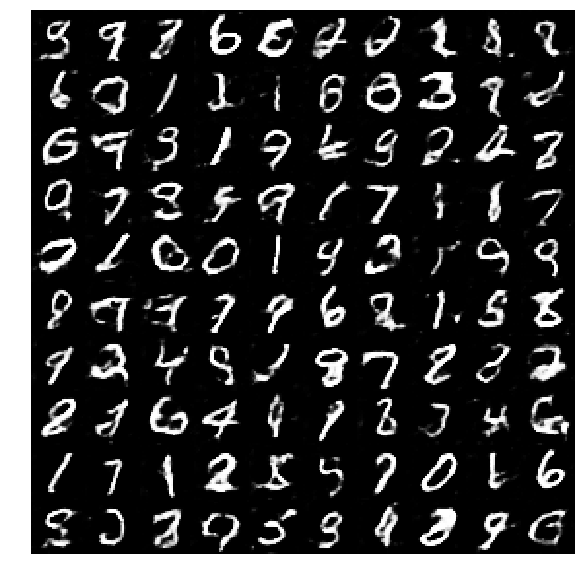

training step 6500: discriminator loss 1.1294313669204712; generator loss 0.22021909058094025
training step 6600: discriminator loss 1.1054832935333252; generator loss 0.7598179578781128


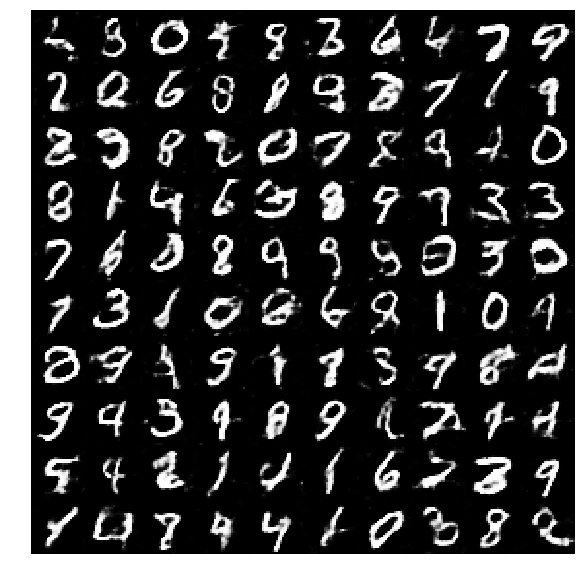

training step 6700: discriminator loss 1.0384516716003418; generator loss 0.7384317517280579
training step 6800: discriminator loss 1.3091243505477905; generator loss -0.13623511791229248


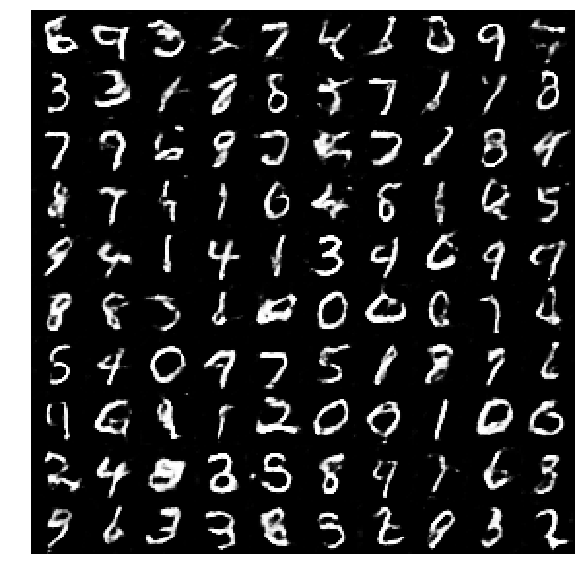

training step 6900: discriminator loss 1.2212774753570557; generator loss -0.08230423927307129
training step 7000: discriminator loss 1.042008399963379; generator loss 0.1354464590549469


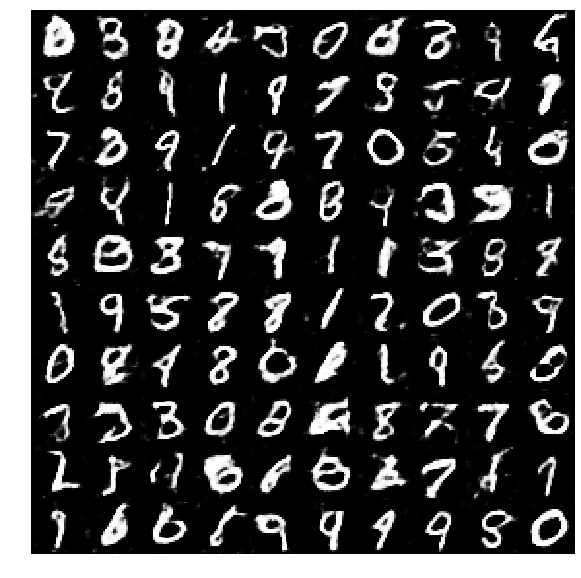

training step 7100: discriminator loss 1.3680167198181152; generator loss 0.8591694831848145
training step 7200: discriminator loss 1.1809090375900269; generator loss 0.09099212288856506


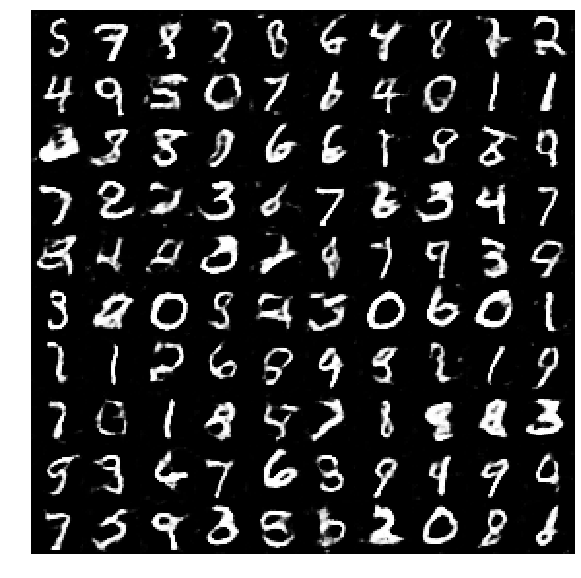

training step 7300: discriminator loss 1.0246338844299316; generator loss 0.8107721209526062
training step 7400: discriminator loss 1.1433963775634766; generator loss 0.7441137433052063


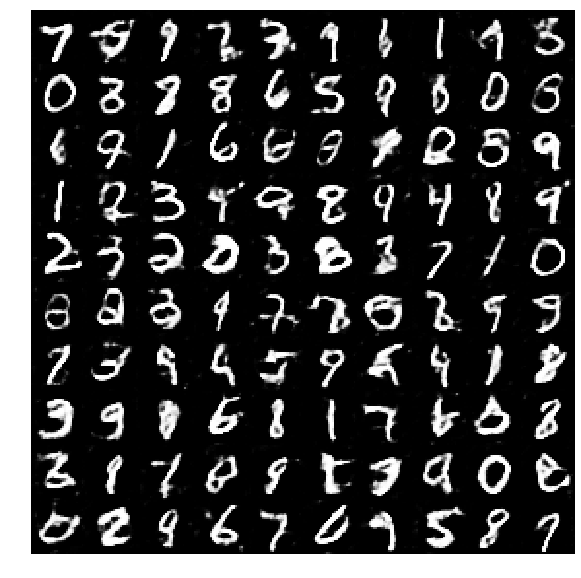

training step 7500: discriminator loss 1.150050163269043; generator loss 0.8103584051132202
training step 7600: discriminator loss 1.2626948356628418; generator loss 0.3095451593399048


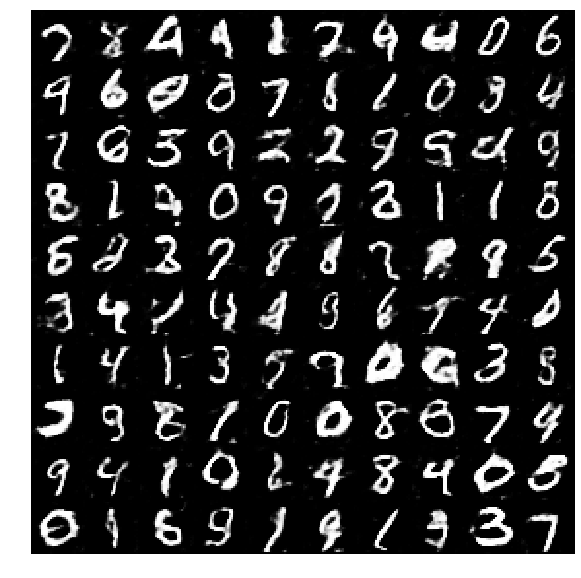

training step 7700: discriminator loss 1.0493979454040527; generator loss 0.17276889085769653
training step 7800: discriminator loss 1.3177874088287354; generator loss -0.09216150641441345


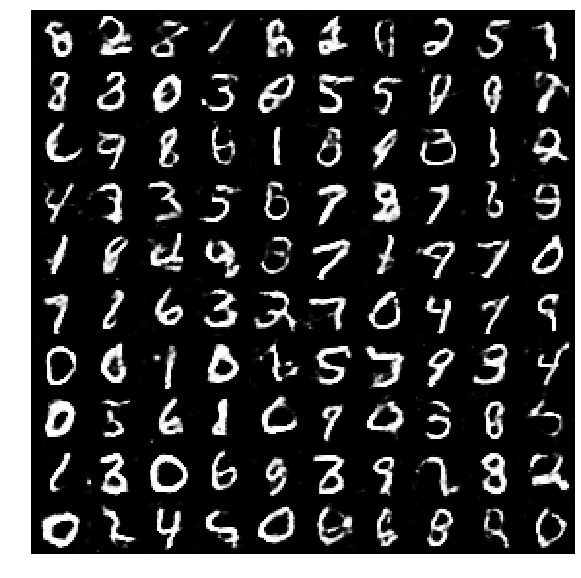

training step 7900: discriminator loss 1.2028127908706665; generator loss 0.861098051071167
training step 8000: discriminator loss 1.3066482543945312; generator loss 0.7989151477813721


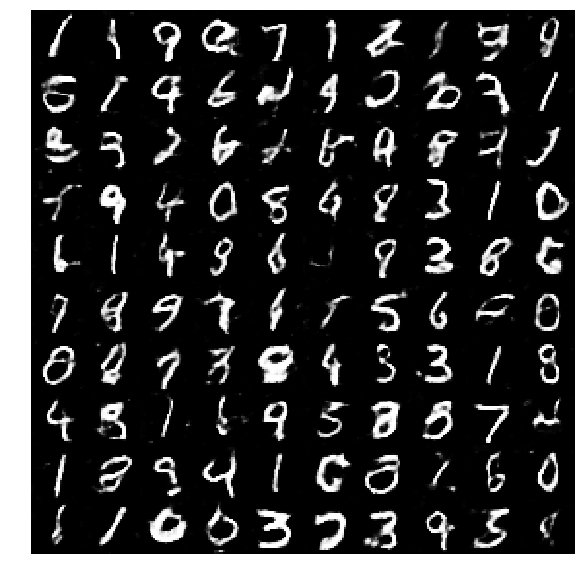

training step 8100: discriminator loss 1.296360731124878; generator loss -0.02253078669309616
training step 8200: discriminator loss 1.264481782913208; generator loss 0.8235963582992554


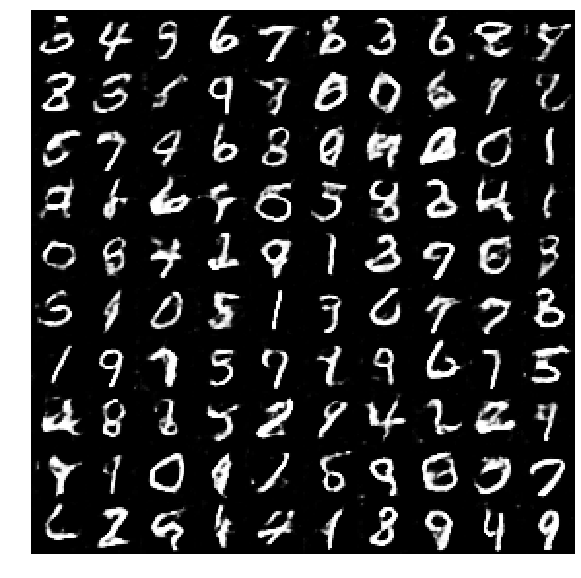

training step 8300: discriminator loss 1.080671787261963; generator loss 0.3063042461872101
training step 8400: discriminator loss 0.9851493835449219; generator loss 0.5266967415809631


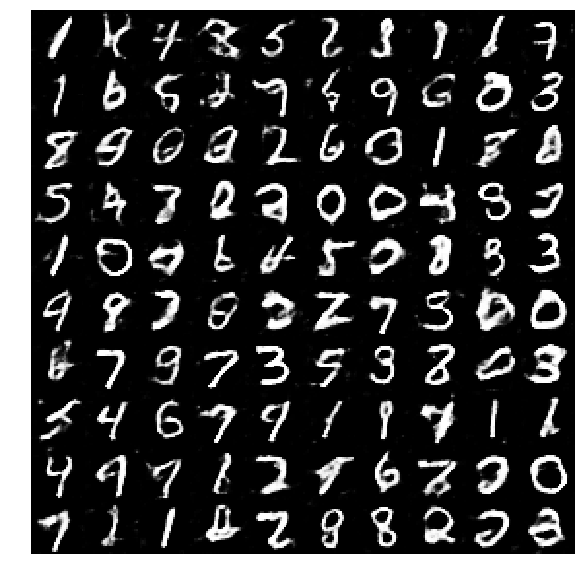

training step 8500: discriminator loss 1.305041790008545; generator loss 0.9283215999603271
training step 8600: discriminator loss 0.8919463157653809; generator loss 0.8148887157440186


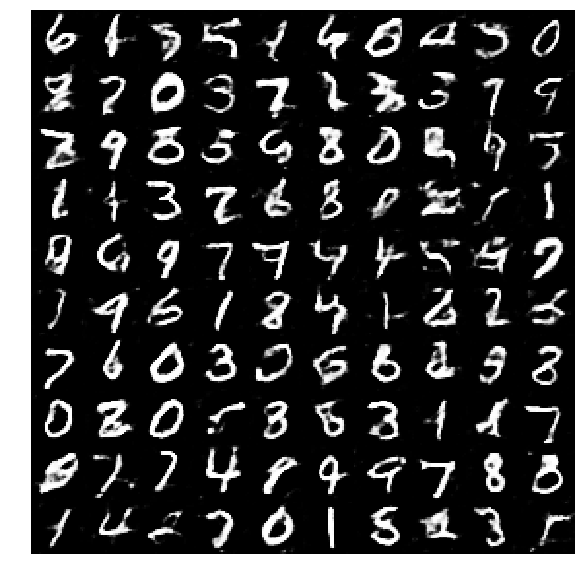

training step 8700: discriminator loss 1.0454585552215576; generator loss 0.5516787767410278
training step 8800: discriminator loss 1.1690075397491455; generator loss 0.7788459062576294


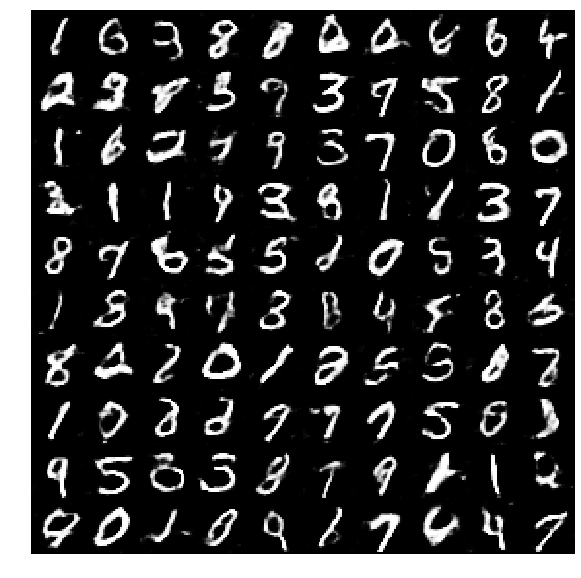

training step 8900: discriminator loss 0.9689000248908997; generator loss 0.8294426202774048
training step 9000: discriminator loss 1.1452929973602295; generator loss 0.6875177025794983


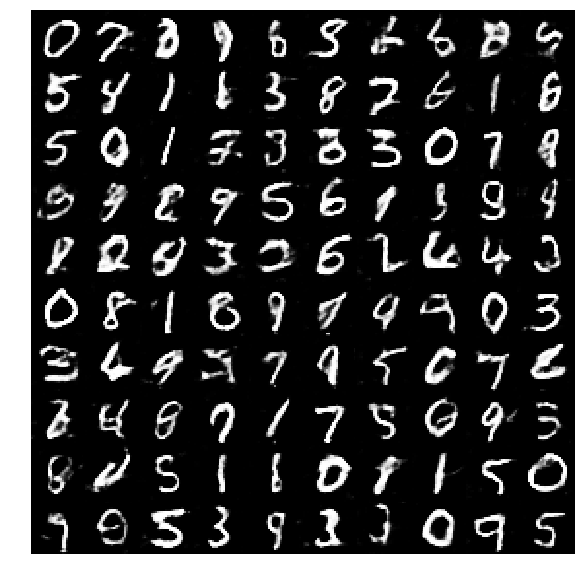

training step 9100: discriminator loss 0.9634589552879333; generator loss 0.6696203351020813
training step 9200: discriminator loss 1.1191166639328003; generator loss 0.865339994430542


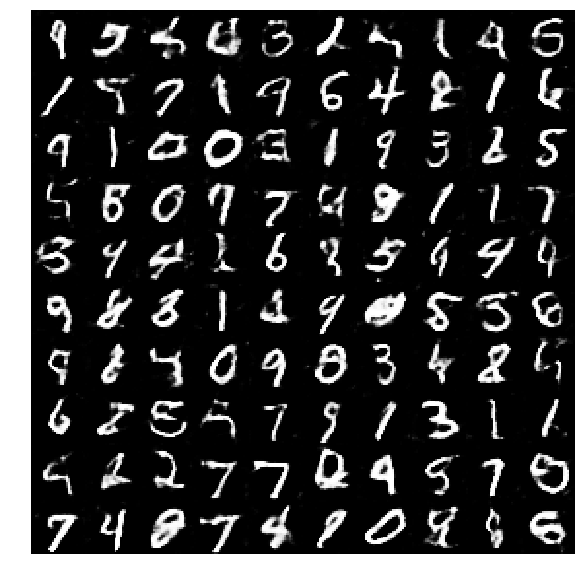

training step 9300: discriminator loss 1.1160272359848022; generator loss 0.811830997467041
training step 9400: discriminator loss 1.2681939601898193; generator loss -0.060750123113393784


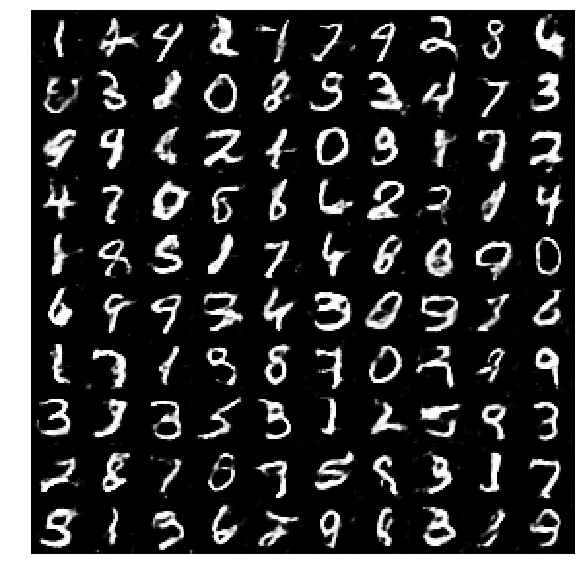

training step 9500: discriminator loss 1.037258267402649; generator loss 0.28899574279785156
training step 9600: discriminator loss 1.1258344650268555; generator loss 0.5817208290100098


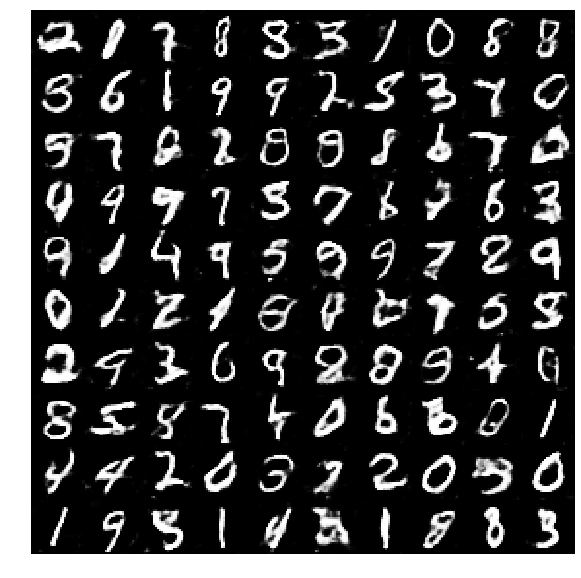

training step 9700: discriminator loss 0.879216730594635; generator loss 0.4621622562408447
training step 9800: discriminator loss 0.993300199508667; generator loss 0.24354597926139832


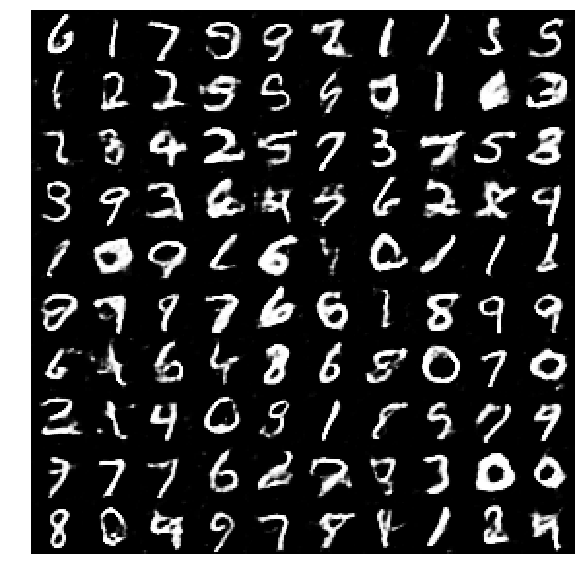

training step 9900: discriminator loss 1.243842601776123; generator loss 0.8519885540008545
training step 10000: discriminator loss 1.1125004291534424; generator loss 0.44184744358062744


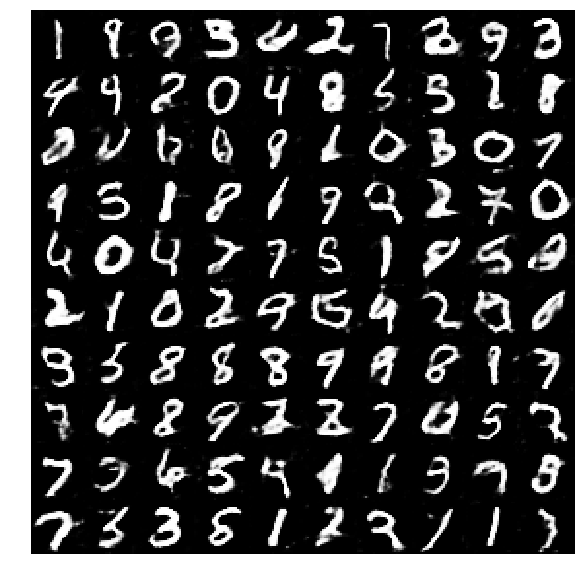

training step 10100: discriminator loss 1.0849506855010986; generator loss 0.7714301943778992
training step 10200: discriminator loss 1.032593011856079; generator loss 0.2833426594734192


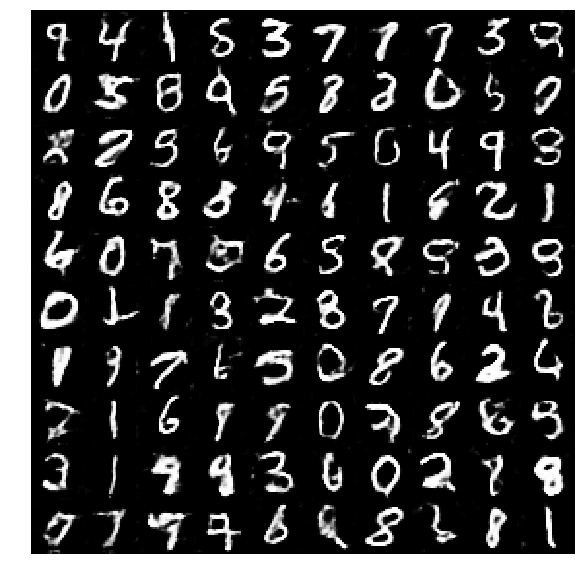

training step 10300: discriminator loss 1.010157823562622; generator loss 0.24620984494686127
training step 10400: discriminator loss 0.9888527989387512; generator loss 0.6106092929840088


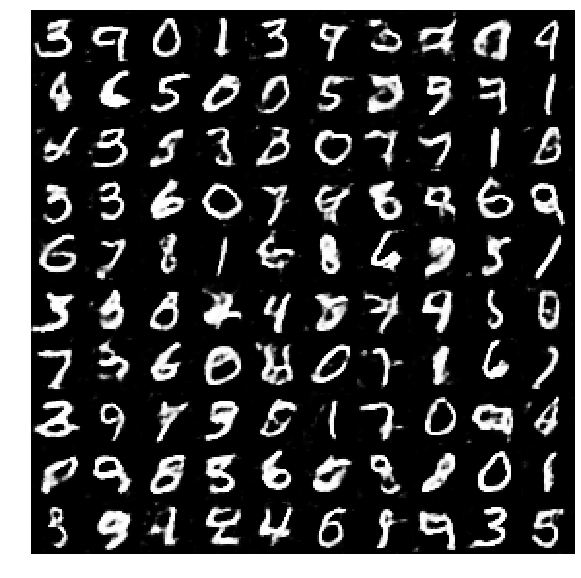

training step 10500: discriminator loss 1.0262597799301147; generator loss 0.7280783653259277
training step 10600: discriminator loss 1.310348391532898; generator loss -0.2186354100704193


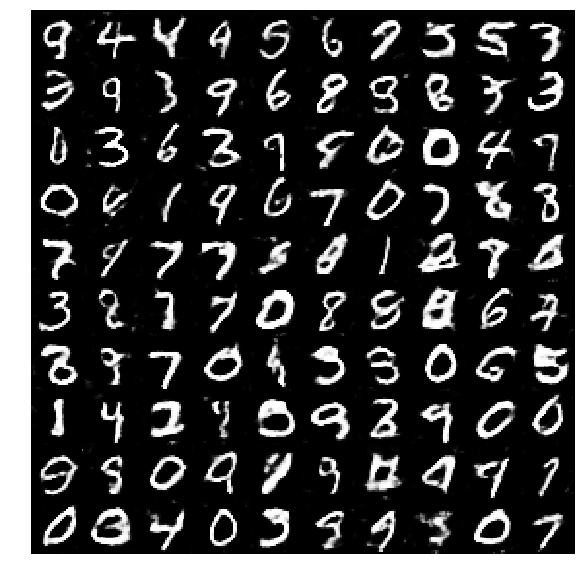

training step 10700: discriminator loss 1.0968126058578491; generator loss 0.8499490022659302
training step 10800: discriminator loss 1.439283847808838; generator loss -0.3162381052970886


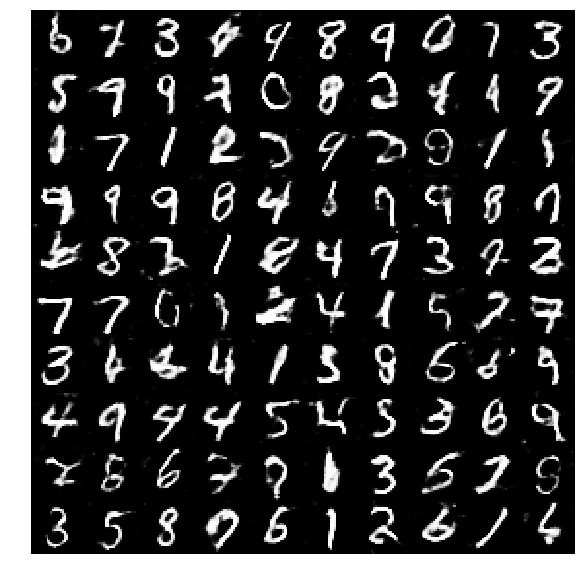

training step 10900: discriminator loss 0.9798007607460022; generator loss 0.3063009977340698
training step 11000: discriminator loss 1.2184382677078247; generator loss 0.728560209274292


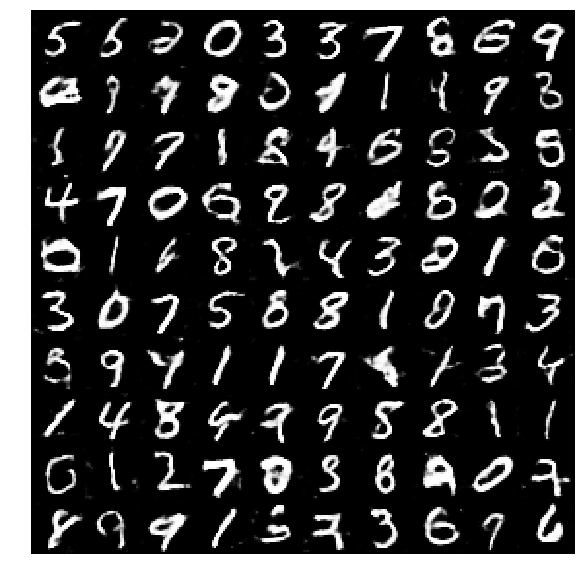

training step 11100: discriminator loss 1.2936524152755737; generator loss -0.18496383726596832
training step 11200: discriminator loss 1.2721083164215088; generator loss 0.9144366979598999


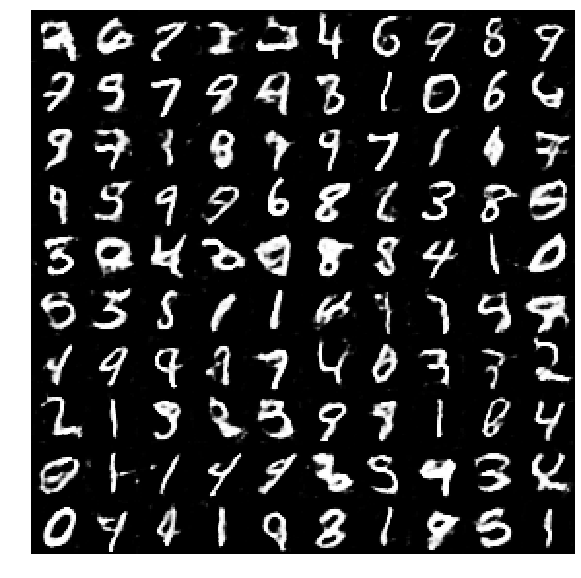

training step 11300: discriminator loss 1.0793801546096802; generator loss 0.08120124042034149
training step 11400: discriminator loss 1.0751250982284546; generator loss 0.1827421337366104


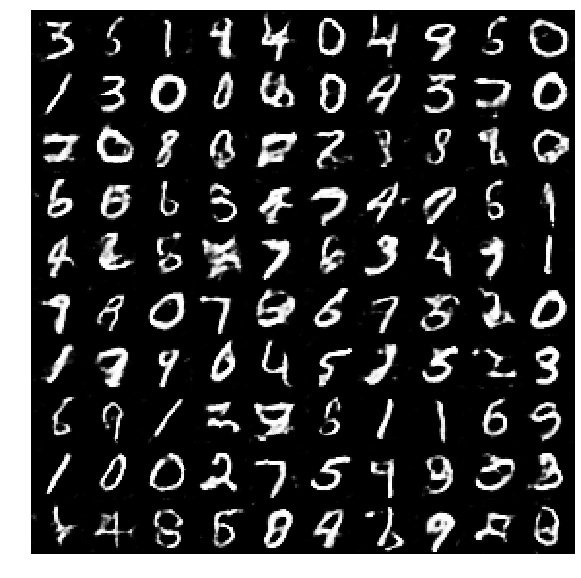

training step 11500: discriminator loss 1.468653678894043; generator loss 0.9342761039733887
training step 11600: discriminator loss 1.1658055782318115; generator loss 0.8289072513580322


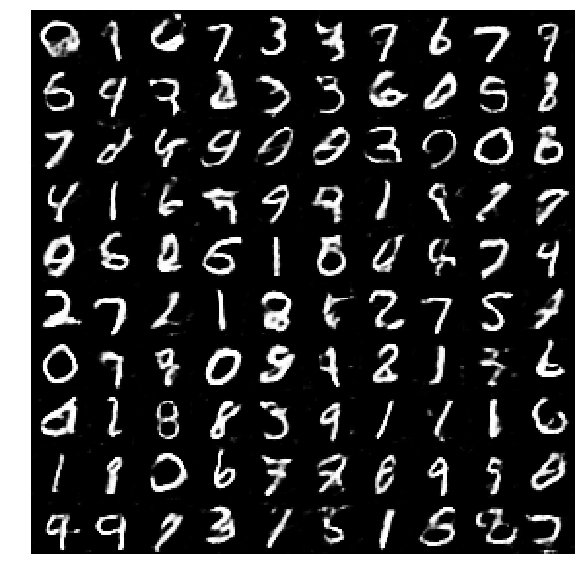

training step 11700: discriminator loss 0.983060359954834; generator loss 0.6484466791152954
training step 11800: discriminator loss 1.120038628578186; generator loss -0.06142260879278183


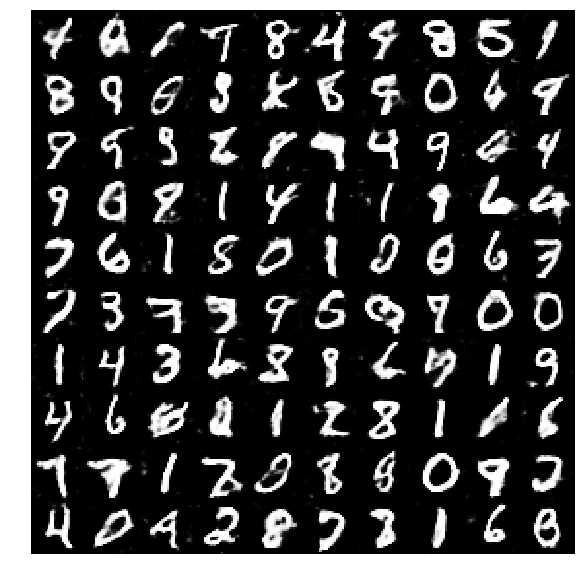

In [17]:
global_step = tf.train.get_or_create_global_step()

d_losses, g_losses = [], []


for real_img_batch in dataset:

    input_z = tf.random_normal(shape=(BATCH_SIZE, LATENT_DIM), dtype='float32')

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
      
        g_fake_images = g_net(input_z, training=True)

        d_logits_fake = d_net(g_fake_images, training=True)

        d_logits_real = d_net(real_img_batch, training=True)

        g_loss = compute_g_loss(d_logits_fake)
        g_losses.append(g_loss)
        
        d_loss = compute_d_loss(d_logits_real, d_logits_fake)
        d_losses.append(d_loss)
        
                          
        d_variables = d_net.variables
        g_variables = g_net.variables
                
        d_grads = d_tape.gradient(d_loss, d_variables)
        g_grads = g_tape.gradient(g_loss, g_variables)

        d_optimizer.apply_gradients(zip(d_grads, d_variables),
                                    global_step=global_step)
        g_optimizer.apply_gradients(zip(g_grads, g_variables),
                                    global_step=global_step)

    
    step = global_step.numpy()
    
    if step % 100==0:
        print('training step {}: discriminator loss {}; generator loss {}'\
              .format(step, d_loss, g_loss))
    
    if step % SAMPLE_PER_N_STEPS==0:      
        eval_z = tf.random_normal(shape=(100, LATENT_DIM), dtype='float32')

        eval_img = g_net(eval_z, training=False)
        
        img_grid = tf.contrib.gan.eval.image_grid(
                        input_tensor=eval_img,
                        grid_shape=(10,10),
                        image_shape=(H, W),
                        num_channels=C
                    )
                
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid[0,:,:,0], cmap='gray')
        plt.axis('off')
        plt.show()